# Importing Packages

In [2]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.quantization
import torchvision

import os

In [2]:
print(torch.backends.quantized.supported_engines)

['qnnpack', 'none', 'onednn', 'x86', 'fbgemm']


# Loading Model and Quantizing

In [3]:
from torchvision.models.quantization import (
    resnet18, resnet50, googlenet, inception_v3, mobilenet_v2, 
    mobilenet_v3_large, resnext101_32x8d, shufflenet_v2_x0_5
)
from torchvision.models.quantization import (
    GoogLeNet_QuantizedWeights, Inception_V3_QuantizedWeights, ResNet18_QuantizedWeights, 
    ResNet50_QuantizedWeights, MobileNet_V2_QuantizedWeights, 
    MobileNet_V3_Large_QuantizedWeights, ResNeXt101_32X8D_QuantizedWeights, 
    ShuffleNet_V2_X0_5_QuantizedWeights
)

# Dictionary to map model names to their corresponding weights classes
model_weights = {
    "googlenet": GoogLeNet_QuantizedWeights,
    "inception_v3": Inception_V3_QuantizedWeights,
    "resnet18": ResNet18_QuantizedWeights,
    "resnet50": ResNet50_QuantizedWeights,
    "mobilenet_v2": MobileNet_V2_QuantizedWeights,
    "mobilenet_v3_large": MobileNet_V3_Large_QuantizedWeights,
    "resnext101_32x8d": ResNeXt101_32X8D_QuantizedWeights,
    "shufflenet_v2_x0_5": ShuffleNet_V2_X0_5_QuantizedWeights
}

# Dictionary to map model names to their corresponding constructors
model_constructors = {
    "googlenet": googlenet,
    "inception_v3": inception_v3,
    "resnet18": resnet18,
    "resnet50": resnet50,
    "mobilenet_v2": mobilenet_v2,
    "mobilenet_v3_large": mobilenet_v3_large,
    "resnext101_32x8d": resnext101_32x8d,
    "shufflenet_v2_x0_5": shufflenet_v2_x0_5
}

# Load all models with their best available weights and preprocess functions
quant_models = []

for model_name in model_weights:
    weights = model_weights[model_name].DEFAULT
    try:
        model = model_constructors[model_name](weights=weights, quantize=True)
        print("Loaded model", model_name)
    except:
        print("Skipping model", model_name)
        continue
    model.eval()
    quant_models.append((model_name, model))

Skipping model googlenet


/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Skipping model inception_v3
Skipping model resnet18
Skipping model resnet50


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Loaded model mobilenet_v2
Loaded model mobilenet_v3_large
Skipping model resnext101_32x8d
Skipping model shufflenet_v2_x0_5


# Functions to Get Activations

In [5]:
# Function to capture intermediate outputs and prepare for quantization
def get_intermediate_outputs(model, input_data):
    intermediate_outputs = []

    def hook_fn(module, input, output):
        intermediate_outputs.append(input)
        intermediate_outputs.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return intermediate_outputs


def get_layer_weights(model, layer_weights=None, parent_name=''):
    if layer_weights is None:
        layer_weights = {}

    for name, layer in model.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        if hasattr(layer, 'weight') and layer.weight is not None:
            layer_weights[f"{full_name}.weight"] = layer.weight.detach().cpu().clone()
        if hasattr(layer, 'bias') and layer.bias is not None:
            layer_weights[f"{full_name}.bias"] = layer.bias.detach().cpu().clone()
        
        # Recursively capture weights of submodules
        get_layer_weights(layer, layer_weights, full_name)

    return layer_weights


# Quantize and save all tensors
def save_tensor_as_list(tensor, filename):
    tensor_list = tensor.cpu().numpy().tolist()  # Convert tensor to list
    with open(filename, 'w') as f:
        json.dump(tensor_list, f)
        
# save tensors as numpy files
def save_tensor_as_npy(tensor, filename):
    tensor_list = tensor.cpu().numpy()  # Convert tensor to list
    np.save(filename, tensor_list)

In [6]:
class CompTensor:
    def __init__(self, tensor):
        self.tensor = tensor
        self.shape = tensor.shape
        self.flat = tensor.flatten()

    def update_tensor(self):
        # update tensor with new values from self.flatten
        self.tensor = self.flatten.reshape(self.shape)
        
    def update_flatten(self):
        # update flatten with new values from self.tensor
        self.flat = self.tensor.flatten()
        
    def to(self, type):
        self.tensor = self.tensor.to(type)
        self.update_flatten()
        
        return self

# Generate Traces

In [7]:
# for each model, quantize and save tensors
n_layers = [] # number of layers per model

for k, model in enumerate(quant_models):
    print(f"Quantizing model {model[0]}")
    # Define an input tensor with appropriate shape
    input_tensors = [torch.randn(1, 3, 224, 224) for i in range(9)]  # For a single image of size 224x224 with 3 channels (RGB)

    # Capture intermediate outputs
    intermediate_outputs = []
    for data in input_tensors:
        intermediate_outputs.append(get_intermediate_outputs(model[1], data))
        
    # group tensors by layer
    layerwise_tensors = {}
    for i in range(len(intermediate_outputs)):
        for j in range(1,len(intermediate_outputs[i])-1): # only consider intermediate tensors (skip input and output)
            if j not in layerwise_tensors:
                layerwise_tensors[j] = []
            if intermediate_outputs[i][j][0].is_quantized:
                layerwise_tensors[j].append(intermediate_outputs[i][j][0].int_repr())
            else:
                layerwise_tensors[j].append(intermediate_outputs[i][j][0])

    # convert lists to tensors
    for j in layerwise_tensors:
        layerwise_tensors[j] = torch.stack(layerwise_tensors[j])
        
    # # print tensors
    # for j in layerwise_tensors:
    #     print(j, layerwise_tensors[j].shape)
        
        
    # Get unique values for each layer
    unique_layerwise_tensors = {}
    for j in layerwise_tensors:
        unique_layerwise_tensors[j] = torch.unique(layerwise_tensors[j].flatten())

    # print("Unique values per layer:")
    # for key, value in unique_layerwise_tensors.items():
    #     print(f"Layer {key}:")
    #     print(value)
        
    # flatten layerwise tensors
    flatten_layerwise_tensors = []

    for key in layerwise_tensors:
        flatten_layerwise_tensors.append(CompTensor((layerwise_tensors[key]).flatten()))
        
    # save all tensors as numpy files
    d = "trace/" + model[0] + "/"
        
    print("Saving tensors to", d)
    
    os.makedirs(os.path.dirname(d), exist_ok=True)
    
    for i in range(1, len(flatten_layerwise_tensors) + 1):
        save_tensor_as_npy(flatten_layerwise_tensors[i - 1].to(torch.uint8).tensor, d + "input_" + str(i) + "_flat.npy")
        
    for i in range(1,len(layerwise_tensors) + 1):
        save_tensor_as_npy(layerwise_tensors[i].to(torch.uint8), d + "input_" + str(i) + ".npy")
        
    n_layers.append(len(layerwise_tensors))

Quantizing model googlenet
Saving tensors to trace/googlenet/
Quantizing model inception_v3
Saving tensors to trace/inception_v3/
Quantizing model resnet18
Saving tensors to trace/resnet18/
Quantizing model resnet50
Saving tensors to trace/resnet50/
Quantizing model mobilenet_v2
Saving tensors to trace/mobilenet_v2/
Quantizing model mobilenet_v3_large
Saving tensors to trace/mobilenet_v3_large/
Quantizing model resnext101_32x8d
Saving tensors to trace/resnext101_32x8d/
Quantizing model shufflenet_v2_x0_5
Saving tensors to trace/shufflenet_v2_x0_5/


# Generating Symbol Tables for Traces

In [9]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
from tqdm import tqdm

e_size = 8  # Number of bits per element

for k, model in enumerate((quant_models)):
    print(f"Running Atalanta on model {model[0]}")

    for i in (range(1, n_layers[k] + 1)):
        print("\tRunning Atalanta on input_" + str(i) + "_flat.npy")
        #tqdm.write(f"\tRunning Atalanta on input_{i}_flat.npy")

        # Define file to get trace from
        trace = f"trace/{model[0]}/input_{i}_flat.npy"

        # Define command
        command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
        
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True)

Running Atalanta on model googlenet
	Running Atalanta on input_1_flat.npy
	Running Atalanta on input_2_flat.npy
	Running Atalanta on input_3_flat.npy
	Running Atalanta on input_4_flat.npy
	Running Atalanta on input_5_flat.npy
	Running Atalanta on input_6_flat.npy
	Running Atalanta on input_7_flat.npy
	Running Atalanta on input_8_flat.npy
	Running Atalanta on input_9_flat.npy
	Running Atalanta on input_10_flat.npy
	Running Atalanta on input_11_flat.npy
	Running Atalanta on input_12_flat.npy
	Running Atalanta on input_13_flat.npy
	Running Atalanta on input_14_flat.npy
	Running Atalanta on input_15_flat.npy
	Running Atalanta on input_16_flat.npy
	Running Atalanta on input_17_flat.npy
	Running Atalanta on input_18_flat.npy
	Running Atalanta on input_19_flat.npy
	Running Atalanta on input_20_flat.npy
	Running Atalanta on input_21_flat.npy
	Running Atalanta on input_22_flat.npy
	Running Atalanta on input_23_flat.npy
	Running Atalanta on input_24_flat.npy
	Running Atalanta on input_25_flat.np

In [10]:
for i in range(1, 7):
    print(layerwise_tensors[i].flatten().shape)

torch.Size([1354752])
torch.Size([1354752])
torch.Size([2709504])
torch.Size([2709504])
torch.Size([677376])
torch.Size([677376])


Matplotlib is building the font cache; this may take a moment.


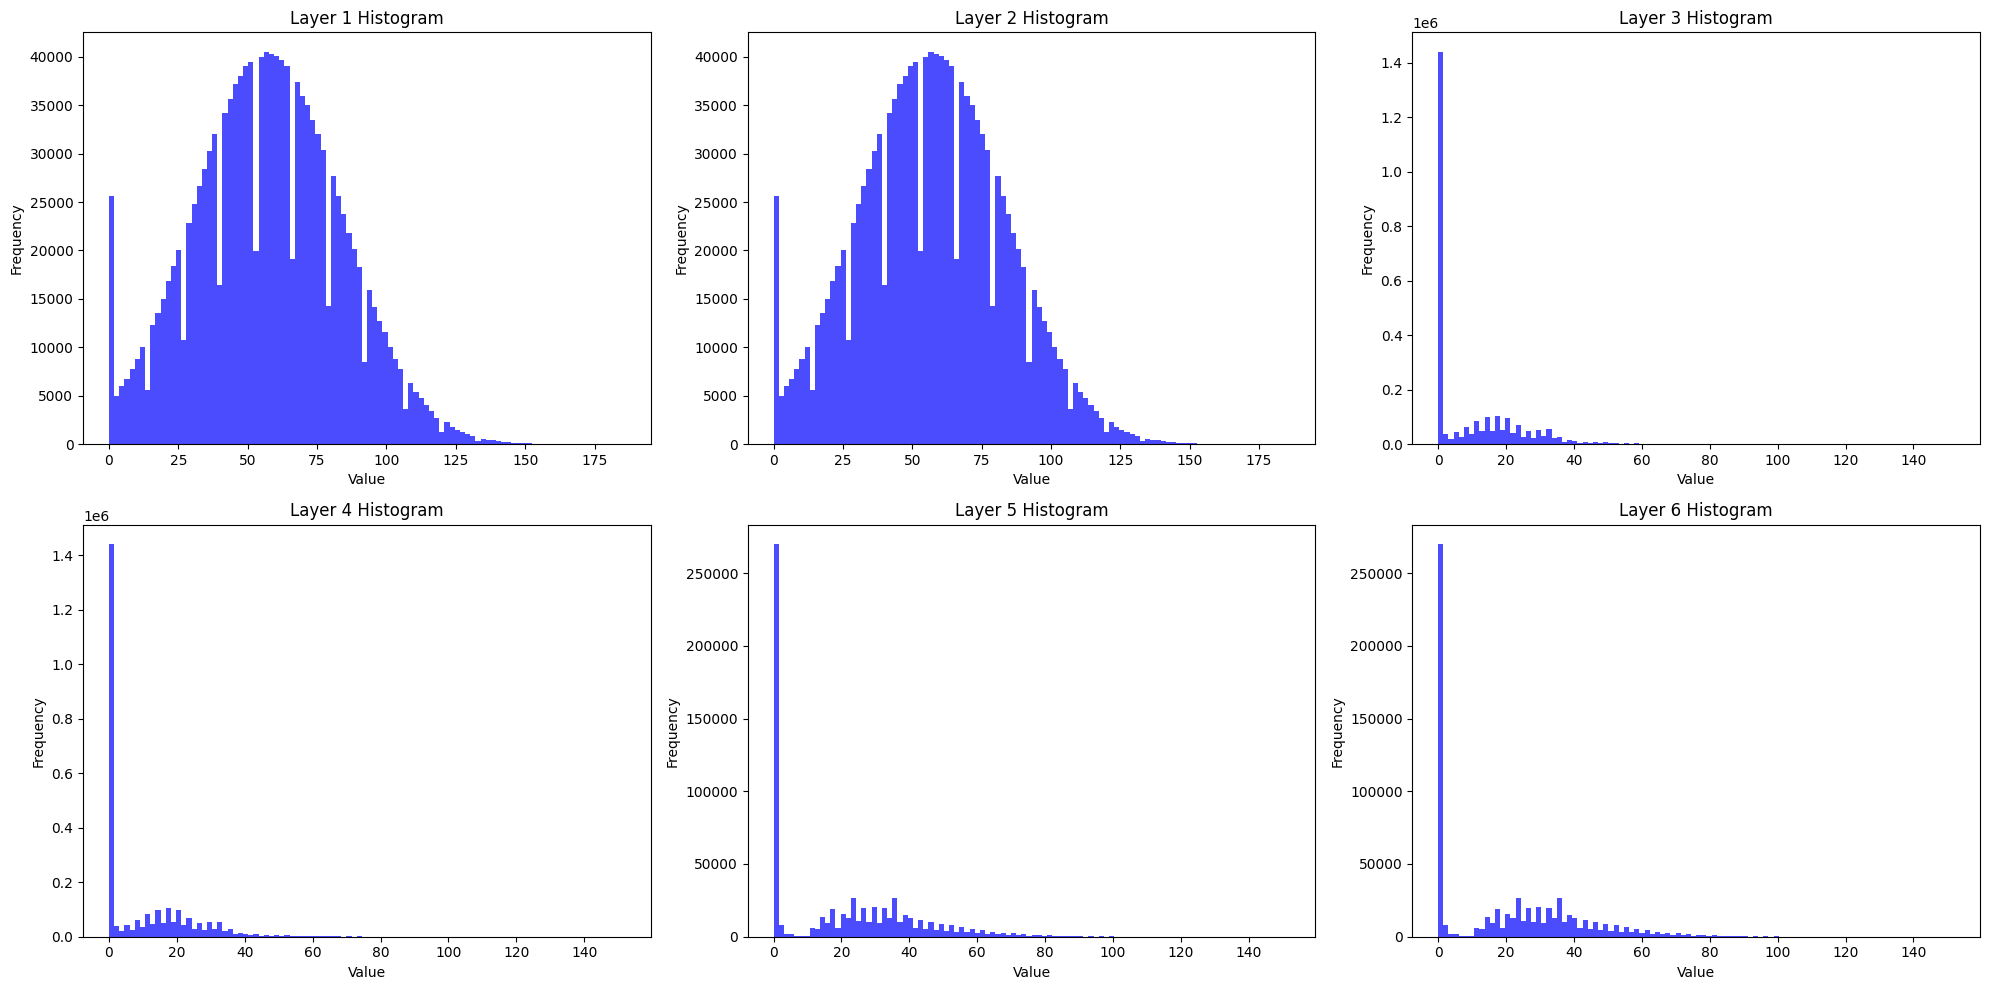

In [12]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(6):
    temp = flatten_layerwise_tensors[i]
    
    # Plot temp as histogram
    axes[i].hist(temp.flat.cpu().numpy(), bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i+1} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Generating Weights

In [13]:
# Function to extract weights and biases into numpy arrays, handling quantized tensors
def extract_weights_biases(model):
    weights_biases = []
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        if isinstance(param, torch.Tensor):
            if 'weight' in name:
                if param.is_quantized:
                    # Dequantize the quantized tensor and change from qint8 to int8
                    param = param.int_repr()
                    # Convert int8 to uint8
                    param = param.to(torch.uint8)
                weights_biases.append(param.detach().cpu().numpy())
    return weights_biases

n_layers = []

for k, model in enumerate(quant_models):
    print(f"Extracting weights and biases for model {model[0]}")
    # Extract weights and biases into numpy arrays
    weights_biases = extract_weights_biases(model[1])

    # Save the extracted weights and biases
    d = "trace/" + model[0] + "/"
    os.makedirs(os.path.dirname(d), exist_ok=True)
    for i in range(len(weights_biases)):
        np.save(d + "weight_" + str(i) + ".npy", weights_biases[i])
        np.save(d + "weight_" + str(i) + "_flat.npy", weights_biases[i].flatten())
    n_layers.append(len(weights_biases))

Extracting weights and biases for model googlenet
Extracting weights and biases for model inception_v3
Extracting weights and biases for model resnet18
Extracting weights and biases for model resnet50
Extracting weights and biases for model mobilenet_v2
Extracting weights and biases for model mobilenet_v3_large
Extracting weights and biases for model resnext101_32x8d
Extracting weights and biases for model shufflenet_v2_x0_5


# Generating Symbol Tables for Weights

In [4]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
import os

e_size = 8 # number of bits per element

for k, model in enumerate(model_weights.keys()):
    print(f"Running Atalanta on model {model[0]}")

    for i in range(n_layers[k]):
        print("\tRunning Atalanta on weight_" + str(i) + ".npy")
        
        # define file to get trace from
        trace = "trace/" + model[0] + "/weight_" + str(i) + "_flat.npy"

        # define command
        command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
        
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True)

Running Atalanta on model g


NameError: name 'n_layers' is not defined

/var/folders/0x/stfy9wr95_36z0f9gkmph_x40000gn/T/ipykernel_16620/699624443.py:20: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


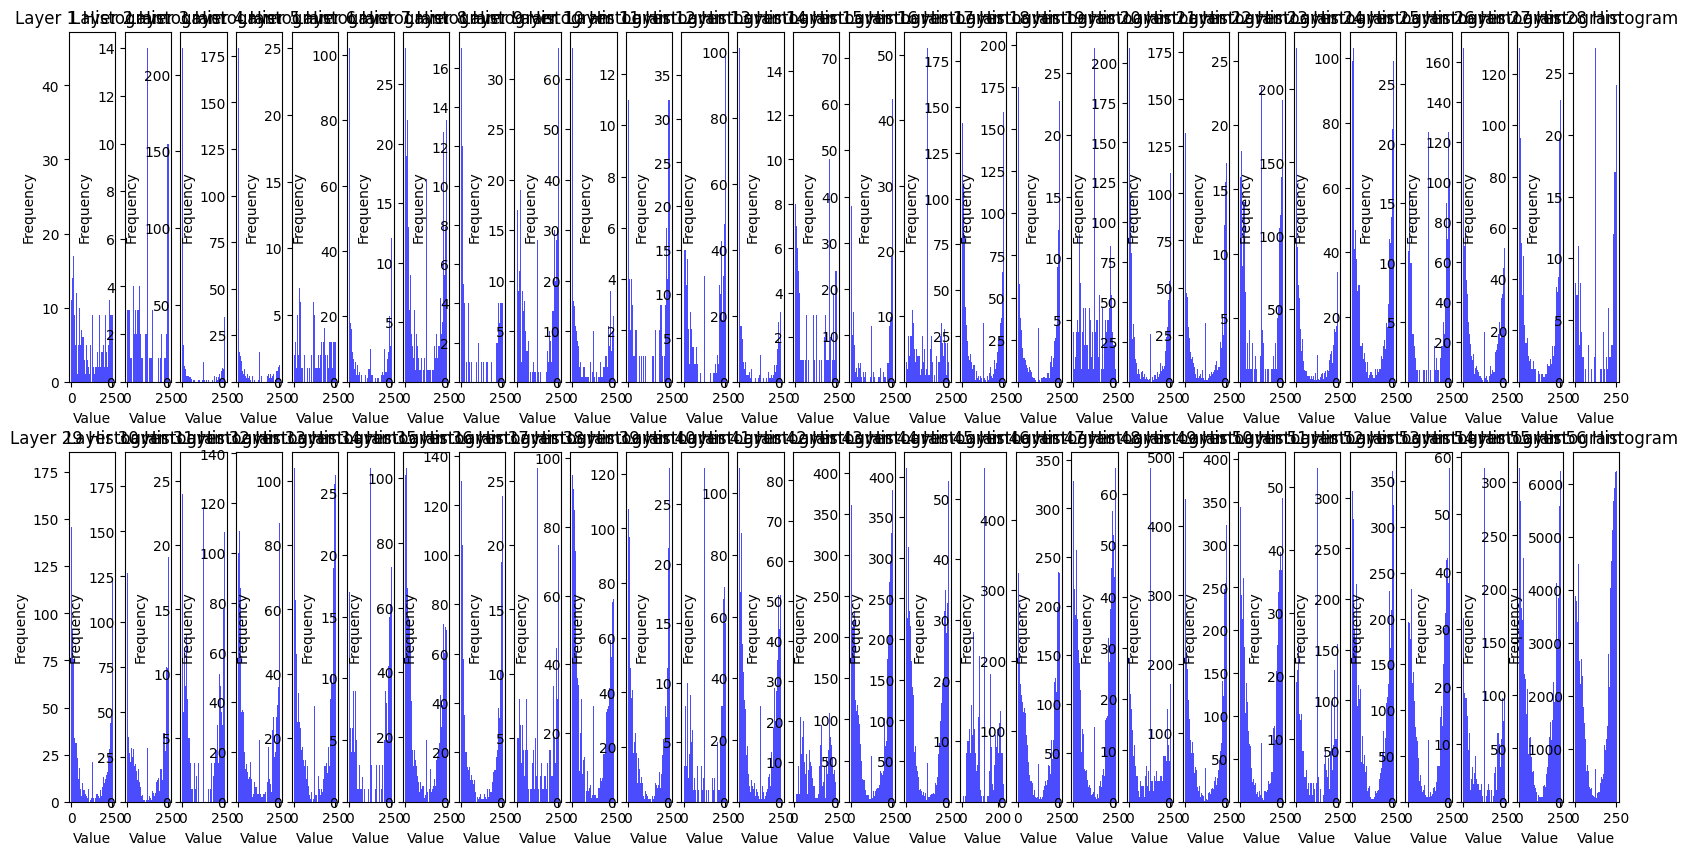

In [15]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, len(weights_biases)//2, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(len(weights_biases)):
    temp = weights_biases[i].flatten()
    
    # Plot temp as histogram
    axes[i].hist(temp, bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i+1} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
